# [Exp-05]RockPaperScissors

## 라이브러리 확인

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.9.1
1.23.1


## 데이터 불러오고 Resize 하기

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os

In [3]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

가위 바위 보 이미지를 불러와서 resize 합니다.

In [4]:
image_dir_path1 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train1/scissor"
resize_images(image_dir_path1)

image_dir_path2 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train1/rock"
resize_images(image_dir_path2)

image_dir_path3 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train1/paper"
resize_images(image_dir_path3)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


## train 데이터 설정

In [5]:
import numpy as np

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/Code/Exploration_Submit/5/train1"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


300개의 28x28x3(rgb) 입니다.

이미지 출력

라벨:  0


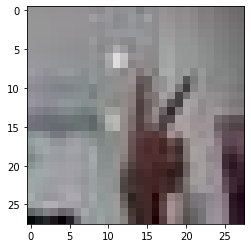

In [6]:
plt.imshow(x_train_norm[0])
print('라벨: ', y_train[0])

In [7]:
print(x_train_norm[0].shape)
print(y_train[0])


(28, 28, 3)
0


## 딥러닝 네트워크 설계하기

* 기존의 예제의 채널 1개에서 3개로 증가
* 최종 class의 개수가 10 -> 3

In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 32)                5

2022-08-09 14:45:33.198785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 14:45:33.228139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 14:45:33.228307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 14:45:33.228974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## 딥러닝 네트워크 학습

In [9]:
x_train_norm.shape

(300, 28, 28, 3)

In [10]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=10)

Epoch 1/10


2022-08-09 14:45:35.147581: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


10/10 [==============================] - 2s 10ms/step - loss: 1.0810 - accuracy: 0.3733
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 1.0086 - accuracy: 0.5767
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.9129 - accuracy: 0.6267
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 0.7246 - accuracy: 0.8700
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.5766 - accuracy: 0.7367
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.4024 - accuracy: 0.8700
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.2900 - accuracy: 0.9300
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.2172 - accuracy: 0.9233
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.1604 - accuracy: 0.9667
Epoch 10/10
10/10 [==============================] - 0s 4ms/step - loss: 0.1279 - accuracy: 0.9767


## 성능 확인

성능 확인을 위해 test data를 만들어 봅시다.

test 이미지를 resize 합시다.

In [11]:
test_image_dir_path1 = os.getenv("HOME") + "/Code/Exploration_Submit/5/test/scissor"
resize_images(test_image_dir_path1)

test_image_dir_path2 = os.getenv("HOME") + "/Code/Exploration_Submit/5/test/rock"
resize_images(test_image_dir_path2)

test_image_dir_path3 = os.getenv("HOME") + "/Code/Exploration_Submit/5/test/paper"
resize_images(test_image_dir_path3)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


In [12]:
test_image_dir_path = os.getenv("HOME") + "/Code/Exploration_Submit/5/test"
(x_test, y_test)=load_data(test_image_dir_path)
x_test_norm = x_test/255.0

학습데이터(x_train)의 이미지 개수는 300 입니다.


제대로 되었는지 확인

(28, 28, 3)
라벨:  1


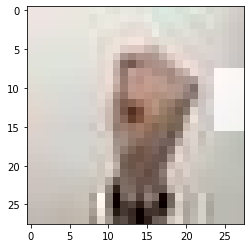

In [13]:
plt.imshow(x_test_norm[150])
print(x_test_norm[0].shape)
print('라벨: ', y_test[150])

evaluate 해서 test_accurcay를 구해봅시다.

In [14]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 2.7827 - accuracy: 0.3467 - 154ms/epoch - 15ms/step
test_loss: 2.782731533050537 
test_accuracy: 0.3466666638851166


## 더 나은 모델 설정

정확도가 너무 낮으니 하이퍼 파라미터를 바꿔봅시다.

In [15]:
def RPS_predict(n_channel_1 = 16, n_channel_2=32 , n_dense=32, n_train_epoch=10):
    model=keras.models.Sequential()
    model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(n_dense, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))

    # model.summary()
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # 모델 훈련 
    # model.fit(x_train_norm, y_train, epochs=n_train_epoch, verbose = 1)
    model.fit(x_train_norm, y_train, epochs=n_train_epoch, verbose = 0)

    # 모델 시험
    test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=0)
    print(n_channel_1, n_channel_2, n_dense, n_train_epoch, ": test_loss: {} ".format(test_loss))
    print(n_channel_1, n_channel_2, n_dense, n_train_epoch, ": test_accuracy: {}".format(test_accuracy))
    
    return test_loss, test_accuracy

In [16]:
RPS_predict(8,16,8,12)

8 16 8 12 : test_loss: 1.2817344665527344 
8 16 8 12 : test_accuracy: 0.4000000059604645


(1.2817344665527344, 0.4000000059604645)

train 데이터의 개수가 모자란 것 같습니다.  
train 데이터를 늘려보겠습니다.

여러개의 train을 사용하기위해 폴더에서 train 폴더만을 사용하겠습니다.

In [17]:
from os import listdir

list_dir = listdir('/home/aiffel/Code/Exploration_Submit/5')
list_train = []
# print(list_dir)
for folder in sorted(list_dir):
    if(folder.startswith('train')):
        list_train.append(folder)

list_train

['train1', 'train2', 'train3', 'train4', 'train5', 'train6']

In [18]:
list_name = ['scissor', 'rock', 'paper']

for i in list_train:
    for j in list_name:
        image_dir_path = os.getenv("HOME") + "/Code/Exploration_Submit/5/" + i + "/"+ j
        # print(image_dir_path)
        resize_images(image_dir_path)
    

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


### 재구축 전 단순 반복 코드 모음

In [19]:
# 재구축 전 반복 코드
# # train 2
# image_dir_path2_1 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train2/scissor"
# resize_images(image_dir_path2_1)
# image_dir_path2_2 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train2/rock"
# resize_images(image_dir_path2_2)
# image_dir_path2_3 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train2/paper"
# resize_images(image_dir_path2_3)

# # train 3
# image_dir_path3_1 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train3/scissor"
# resize_images(image_dir_path3_1)
# image_dir_path3_2 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train3/rock"
# resize_images(image_dir_path3_2)
# image_dir_path3_3 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train3/paper"
# resize_images(image_dir_path3_3)

# # train 4
# image_dir_path4_1 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train4/scissor"
# resize_images(image_dir_path4_1)
# image_dir_path4_2 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train4/rock"
# resize_images(image_dir_path4_2)
# image_dir_path4_3 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train4/paper"
# resize_images(image_dir_path4_3)

# # train 5
# image_dir_path5_1 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train5/scissor"
# resize_images(image_dir_path5_1)
# image_dir_path5_2 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train5/rock"
# resize_images(image_dir_path5_2)
# image_dir_path5_3 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train5/paper"
# resize_images(image_dir_path5_3)

# # train 6
# image_dir_path6_1 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train6/scissor"
# resize_images(image_dir_path6_1)
# image_dir_path6_2 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train6/rock"
# resize_images(image_dir_path6_2)
# image_dir_path6_3 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train6/paper"
# resize_images(image_dir_path6_3)

In [20]:
# 재구축 전 단순 반복 코드 입니다.
# def new_load_data(img_path1, img_path2, img_path3, img_path4, img_path5, img_path6, number_of_data=1800):  # 가위바위보 이미지 개수 총합에 주의하세요.
#     # 가위 : 0, 바위 : 1, 보 : 2
#     img_size=28
#     color=3
#     #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
#     imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
#     labels=np.zeros(number_of_data,dtype=np.int32)
    
#     idx=0
#     # train1 가위
#     for file in glob.iglob(img_path1+'/scissor/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=0   # 가위 : 0
#         idx=idx+1
#     # train2 가위
#     for file in glob.iglob(img_path2+'/scissor/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=0   # 가위 : 0
#         idx=idx+1
#     # train3 가위
#     for file in glob.iglob(img_path3+'/scissor/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=0   # 가위 : 0
#         idx=idx+1
#     # train4 가위
#     for file in glob.iglob(img_path4+'/scissor/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=0   # 가위 : 0
#         idx=idx+1
#     # train5 가위
#     for file in glob.iglob(img_path5+'/scissor/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=0   # 가위 : 0
#         idx=idx+1
#     # train6 가위
#     for file in glob.iglob(img_path6+'/scissor/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=0   # 가위 : 0
#         idx=idx+1
        
#     # train1 바위
#     for file in glob.iglob(img_path1+'/rock/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=1   # 바위 : 1
#         idx=idx+1
#     # train2 바위
#     for file in glob.iglob(img_path2+'/rock/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=1   # 바위 : 1
#         idx=idx+1 
#     # train3 바위
#     for file in glob.iglob(img_path3+'/rock/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=1   # 바위 : 1
#         idx=idx+1  
#     # train4 바위
#     for file in glob.iglob(img_path4+'/rock/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=1   # 바위 : 1
#         idx=idx+1
#     # train5 바위
#     for file in glob.iglob(img_path5+'/rock/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=1   # 바위 : 1
#         idx=idx+1
#     # train6 바위
#     for file in glob.iglob(img_path6+'/rock/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=1   # 바위 : 1
#         idx=idx+1
        
#     # trian1 보
#     for file in glob.iglob(img_path1+'/paper/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=2   # 보 : 2
#         idx=idx+1
#     # trian2 보
#     for file in glob.iglob(img_path2+'/paper/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=2   # 보 : 2
#         idx=idx+1
#     # trian3 보
#     for file in glob.iglob(img_path3+'/paper/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=2   # 보 : 2
#         idx=idx+1
#     # trn4 보
#     for file in glob.iglob(img_path4+'/paper/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=2   # 보 : 2
#         idx=idx+1
#     # trian5 보
#     for file in glob.iglob(img_path5+'/paper/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=2   # 보 : 2
#         idx=idx+1    
# 줄이기 전 단순 반복 코드 입니다.
#     # trian6 보    
#     for file in glob.iglob(img_path6+'/paper/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=2   # 보 : 2
#         idx=idx+1
    
#     print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
#     return imgs, labels

In [21]:
# 재구축 전 단순 반복 코드 입니다.
# img_path1 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train1"
# img_path2 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train2"
# img_path3 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train3"
# img_path4 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train4"
# img_path5 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train5"
# img_path6 = os.getenv("HOME") + "/Code/Exploration_Submit/5/train6"

# (x_train, y_train)=new_load_data(img_path1, img_path2, img_path3, img_path4, img_path5, img_path6, 1800)
# x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

# print("x_train shape: {}".format(x_train_norm.shape))
# print("y_train shape: {}".format(y_train.shape))

### 재구축 후 코드

In [22]:
from os import listdir

# 실제 경로 = /home/aiffel/Code/Exploration_Submit/5/train2/paper
# img_path  = /Code/Exploration_Submit
# list_train = ['train1', 'train2', 'train3', 'train4', 'train5', 'train6']
# list_name = ['scissor', 'rock', 'paper']
def new_load_data(img_path, number_of_data=1800):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    idx = 0
    
    for i in list_train:
        for nidx, name in enumerate(list_name):
            print(i, nidx, name)
            for file in glob.iglob(img_path + "/" + i + "/" + name + "/*.jpg"):
                img = np.array(Image.open(file),dtype=np.int32)
                imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
                labels[idx] = nidx  # 가위 : 0, 바위 : 1, 보 : 2
                idx=idx+1
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [23]:
img_path = os.getenv("HOME") + "/Code/Exploration_Submit/5/"
(x_train, y_train)=new_load_data(img_path, 1800)
x_train_norm = x_train/255.0   # RPS_predict(32,32,64,14)입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train_norm.shape))
print("y_train shape: {}".format(y_train.shape))

train1 0 scissor
train1 1 rock
train1 2 paper
train2 0 scissor
train2 1 rock
train2 2 paper
train3 0 scissor
train3 1 rock
train3 2 paper
train4 0 scissor
train4 1 rock
train4 2 paper
train5 0 scissor
train5 1 rock
train5 2 paper
train6 0 scissor
train6 1 rock
train6 2 paper
학습데이터(x_train)의 이미지 개수는 1800 입니다.
x_train shape: (1800, 28, 28, 3)
y_train shape: (1800,)


다시 구해봅니다.

In [24]:
# 16 32, 16 32, 32 64, 10 13 16
accuracy_list = []

for i in range(1,3):
    for j in range(8, 21, 2):
        RPS_predict(16*i,16*i,32*i, j)
        loss, accuracy = RPS_predict(16*i,16*i,32*i, j)
        accuracy_list.append(accuracy)
        # print(i, j)

16 16 32 8 : test_loss: 1.4814858436584473 
16 16 32 8 : test_accuracy: 0.4166666567325592
16 16 32 8 : test_loss: 1.4490834474563599 
16 16 32 8 : test_accuracy: 0.5400000214576721
16 16 32 10 : test_loss: 1.6562466621398926 
16 16 32 10 : test_accuracy: 0.49000000953674316
16 16 32 10 : test_loss: 1.2815040349960327 
16 16 32 10 : test_accuracy: 0.5533333420753479
16 16 32 12 : test_loss: 1.0923511981964111 
16 16 32 12 : test_accuracy: 0.6333333253860474
16 16 32 12 : test_loss: 2.1837549209594727 
16 16 32 12 : test_accuracy: 0.503333330154419
16 16 32 14 : test_loss: 1.4862370491027832 
16 16 32 14 : test_accuracy: 0.6633333563804626
16 16 32 14 : test_loss: 2.3523550033569336 
16 16 32 14 : test_accuracy: 0.476666659116745
16 16 32 16 : test_loss: 1.8087302446365356 
16 16 32 16 : test_accuracy: 0.5733333230018616
16 16 32 16 : test_loss: 2.1911723613739014 
16 16 32 16 : test_accuracy: 0.44333332777023315
16 16 32 18 : test_loss: 2.0639820098876953 
16 16 32 18 : test_accuracy: 

여러 지표들 중에 accuracy가 0.60이상이 나왔습니다.

## 추가 실험

* 빈공간의 이미지(void)를 새로운 label로 넣고 계산을 해봅시다.

먼저 모든 train 폴더에 있는 void 폴더의 이미지들을 resize 합니다.

In [25]:
for i in list_train:
    image_dir_path = os.getenv("HOME") + "/Code/Exploration_Submit/5/" + i + "/void"
    # print(image_dir_path)
    resize_images(image_dir_path)   

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


원래 3개의 label 에서 4개의 label로 늘려서 train set을 만드는 함수를 만듭니다.

In [26]:
from os import listdir

# 실제 경로 = /home/aiffel/Code/Exploration_Submit/5/train2/paper
# img_path  = /Code/Exploration_Submit
# list_train = ['train1', 'train2', 'train3', 'train4', 'train5', 'train6']
new_list_name = ['scissor', 'rock', 'paper', 'void']
def new2_load_data(img_path, number_of_data = 2400):  # 가위, 바위, 보, 빈공간 이미지 개수 총합 = 400*6 = 2400
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2, 빈 공간 : 3) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    idx = 0
    
    for i in list_train:
        for nidx, name in enumerate(new_list_name):
            print(i, nidx, name)
            for file in glob.iglob(img_path + "/" + i + "/" + name + "/*.jpg"):
                img = np.array(Image.open(file),dtype=np.int32)
                imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
                labels[idx] = nidx  # 가위 : 0, 바위 : 1, 보 : 2, void : 3
                idx=idx+1
    print("새로운 학습데이터(new_x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

train 폴더와 test 폴더의 위치를 지정하고 함수를 대입해서  
새로운 x_train와 y_train을 만듭니다.

In [27]:
img_path = os.getenv("HOME") + "/Code/Exploration_Submit/5/"
(new_x_train, new_y_train)=new2_load_data(img_path, 2400)
new_x_train_norm = new_x_train/255.0   # RPS_predict(32,32,64,14)입력은 0~1 사이의 값으로 정규화

print("new_x_train shape: {}".format(new_x_train_norm.shape))
print("new_y_train shape: {}".format(new_y_train.shape))

train1 0 scissor
train1 1 rock
train1 2 paper
train1 3 void
train2 0 scissor
train2 1 rock
train2 2 paper
train2 3 void
train3 0 scissor
train3 1 rock
train3 2 paper
train3 3 void
train4 0 scissor
train4 1 rock
train4 2 paper
train4 3 void
train5 0 scissor
train5 1 rock
train5 2 paper
train5 3 void
train6 0 scissor
train6 1 rock
train6 2 paper
train6 3 void
새로운 학습데이터(new_x_train)의 이미지 개수는 2400 입니다.
new_x_train shape: (2400, 28, 28, 3)
new_y_train shape: (2400,)


최종 출력 값이 4개인 모델을 만들고 훈련하는 함수를 만듭니다.

In [28]:
def new_RPS_predict(n_channel_1 = 16, n_channel_2=32 , n_dense=32, n_train_epoch=10):
    model=keras.models.Sequential()
    model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(n_dense, activation='relu'))
    model.add(keras.layers.Dense(4, activation='softmax'))
    
    # model.summary()
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    # 모델 훈련 
    # model.fit(x_train_norm, y_train, epochs=n_train_epoch, verbose = 1)
    model.fit(new_x_train_norm, new_y_train, epochs=n_train_epoch, verbose = 0)
    
    # 모델 시험
    test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=0)
    print(n_channel_1, n_channel_2, n_dense, n_train_epoch, ": new_test_loss: {} ".format(test_loss))
    print(n_channel_1, n_channel_2, n_dense, n_train_epoch, ": new_test_accuracy: {}".format(test_accuracy))
    
    return test_loss, test_accuracy

새로운 모델을 여러 하이퍼 파라미터에 따라 값을 구해봅니다.  
test data는 이전과 동일 합니다.(가위, 바위, 보 만)

In [29]:
# 16 32, 16 32, 32 64, 10 13 16
new_accuracy_list = []

for i in range(1,3):
    for j in range(8, 21, 2):
        loss, accuracy = new_RPS_predict(16*i,16*i,32*i, j)
        new_accuracy_list.append(accuracy)
        # print(i, j)

16 16 32 8 : new_test_loss: 1.190024971961975 
16 16 32 8 : new_test_accuracy: 0.4533333480358124
16 16 32 10 : new_test_loss: 1.3372710943222046 
16 16 32 10 : new_test_accuracy: 0.5733333230018616
16 16 32 12 : new_test_loss: 1.477148413658142 
16 16 32 12 : new_test_accuracy: 0.6066666841506958
16 16 32 14 : new_test_loss: 1.8181201219558716 
16 16 32 14 : new_test_accuracy: 0.5099999904632568
16 16 32 16 : new_test_loss: 2.4847989082336426 
16 16 32 16 : new_test_accuracy: 0.3400000035762787
16 16 32 18 : new_test_loss: 2.5542781352996826 
16 16 32 18 : new_test_accuracy: 0.43666666746139526
16 16 32 20 : new_test_loss: 1.9580918550491333 
16 16 32 20 : new_test_accuracy: 0.54666668176651
32 32 64 8 : new_test_loss: 1.7791554927825928 
32 32 64 8 : new_test_accuracy: 0.503333330154419
32 32 64 10 : new_test_loss: 1.8898632526397705 
32 32 64 10 : new_test_accuracy: 0.47999998927116394
32 32 64 12 : new_test_loss: 2.2051591873168945 
32 32 64 12 : new_test_accuracy: 0.51666665077209

이전 accuracy와 새로운 data로 훈련한 결과의 accuracy

[0.5400000214576721, 0.5533333420753479, 0.503333330154419, 0.476666659116745, 0.44333332777023315, 0.54666668176651, 0.6133333444595337, 0.5533333420753479, 0.5566666722297668, 0.5166666507720947, 0.5533333420753479, 0.5299999713897705, 0.5799999833106995, 0.596666693687439]
[0.4533333480358124, 0.5733333230018616, 0.6066666841506958, 0.5099999904632568, 0.3400000035762787, 0.43666666746139526, 0.54666668176651, 0.503333330154419, 0.47999998927116394, 0.5166666507720947, 0.4933333396911621, 0.5600000023841858, 0.54666668176651, 0.5299999713897705]


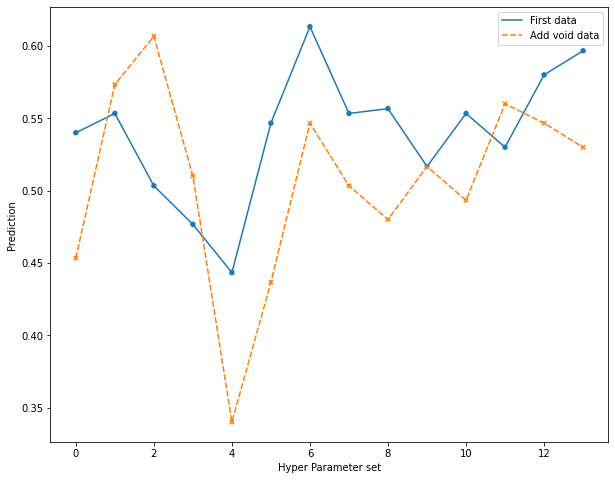

In [30]:
print(accuracy_list)
print(new_accuracy_list)

import seaborn as sns

plt.figure(figsize = (10,8))
sns.lineplot(data = [accuracy_list, new_accuracy_list])
sns.scatterplot(data = [accuracy_list, new_accuracy_list])
plt.legend(['First data', 'Add void data'])
plt.xlabel("Hyper Parameter set")
plt.ylabel("Prediction")
plt.show()

Hyper parameter 값에 따라 기존의 train data로 훈련한 모델의 prediction의 갑이 더 높기도 하고 낮기도 합니다.

### 회고

* 이번 프로젝트에서 어려웠던 점
    - 여러개의 폴더에 효율적인 코드로 traindata를 불러오는 법
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  * 알게 된점
    - listdir 사용법
    - 무작정 traindata를 늘린다고 더 prediction 값이 더 높게 나오는적인 것은 아니다.
  * 아직 모호한 점
    - (왜 코드를 돌릴 때 마다 prediction 값이 다르게 나오는지 모르겠습니다.) - 초기값 설정인 것으로 배웠습니다.
* 루브릭 평가를 맞추기 위해 시도한 점
    - 여러 모델을 만들어보았습니다.
    - 오버피팅을 극복하기 위해 많은 수의 다양한 train data를 넣었고 새로운 label의 data를 추가해보았습니다.
    - 여러 hyperparameter를 설정해서 60% 이상을 넘는 경우를 찾았습니다.